## Praktyczny przykład wykorzystania ANOVA two-way w Pythonie
Source of data: http://faculty.webster.edu/woolflm/8canswer.html

### Model ANOVA two-way (two-factor)

W tej analizie robimy porównie dwóch czyników w tych samych populacjach. 
Porównuje się na przykład temperaturę i ciśnienie w procesie w kilku różnych okresach.
Tworzy się trzy hipotezy zerowe:
- h01: średnia temperatury w procesach jest równa
- h02: średnie ciśnienie w procesach jest równe
- h03: nie ma powiązania między ciśnieniem a temperaturą

Mówimy, że występuje interakcja pomiędzy dwoma czynnikami, jeżeli efekt uzyskany przy danym poziomie jednego czynnika zależy od poziomu drugiego czynnika. Brak interakcji oznacza, że czynniki są addytywne.

Przeprowadzając two-way ANOVA powinniśmy najpierw sprawdzić trzecią hipotezę zerową.  

Analiza ANOVA jest dla H01 i H02 dwiema ANOWA jednoczynnikowymi jednak przy H03 jest już połączeniem tych dwóch ANOVA one-way czyli ANOVA two-way.

### ANOVA trzy czynnikowa 
Polega na trzech hipotezach zerowych ANOVA one-way o równości średnich dla czynników A, B, C oraz kilku hipotez interakcji: AB, AC, BC, ABC.

#### Case Study ANOVA

Przeprowadzono badania, których celem było określenie poziomu *radości życia*. Postawiono następujące hipotezy zerowe:
-  h0a - średnia *radość życia* jest taka sama dla kobiet i mężczyzn
-  H0b - średnia *radość życia* jest taka sama wśród trzech grup: 'Young Adult', 'Middle Adult', 'Older Adult'. 
-  H0c - nie istnieje interakcji pomiędzy grupami: 'Young Adult', 'Middle Adult', 'Older Adult' a płcią badanych osób mającej wpływ na poziom *radość życia*.

In [1]:
import pandas as pd

cc =['Male', 'Male', 'Male', 'Male','Male','Female','Female','Female','Female','Female']
aaa	 = [4,2,3,4,2,7,4,3,6,5]
bbb = [7,5,7,5,6,8,10,7,7,8]
ccc = [10,7,9,8,11,10,9,12,11,13]
df = pd.DataFrame({'Group': cc, 'Young Adult':aaa, 'Middle Adult':bbb, 'Older Adult':ccc })
df

,Group,Young Adult,Middle Adult,Older Adult
0,Male,4,7,10
1,Male,2,5,7
2,Male,3,7,9
3,Male,4,5,8
4,Male,2,6,11
5,Female,7,8,10
6,Female,4,10,9
7,Female,3,7,12
8,Female,6,7,11
9,Female,5,8,13


#### Warunki ANOVA

<span style="color:blue"> Analiza ANOVA to analiza stwierdzająca istnienie różnic pomiędzy średnimi w kilku populacjch. ANOVA weryfikuje zgodność średnich w kilku populachach anlizując ich wariancję. Celem AVONA jest wykrycie różnic między średnimi jednak nazywa się ją analizą wariancji. Założenia stosowania anailzy wariancji ANOVA:</span>
 - <span style="color:blue">Próby zostały pobrane niezależnie od siebie z każdej z r populacji</span>
 - <span style="color:blue">W każdej z r badanych populacji rozkłąd jest normalny o tej samej wariancji. Średnie w r populacjach mogą być równę, lecz nie muszą*</span>

*źródło: Amir D. Aczel, "Statystyka w zarządzaniu" PWN str.391

Spełnienie warunków 1 i 2 jest niezbędne do zastosowania analizy ANOVA. Dopuszcza się rozkłady zbliżone do normalnych. Jeżel rozkłady są silnie skośne itp. znacznie odbiegają od rozkłądów normalnych lub gdy wariancje w przybliżeniu nie są jednakowe nie należy stosować ANOVA. W takim wypadku należy zastosować test nieparametryczny Kruskala-Wallisa.

#### Sprawdzenie czy zmienne niezależne mają rozkłąd normalny. Wyszły nieistotne wartości p-value (tzn. p>0,05). Wszystkie zmienne mają rozkład normalny.

In [2]:
from scipy.stats import normaltest

stat, p = normaltest(df['Young Adult'])
print("Young Adult:  ",'p=%.3f' % p)

stat, p = normaltest(df['Middle Adult'])
print("Middle Adult: ",'p=%.3f' % p)

stat, p = normaltest(df['Older Adult'])
print("Older Adult:  ",'p=%.3f' % p)

Young Adult:   p=0.691
Middle Adult:  p=0.564
Older Adult:   p=0.582


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots()
df.plot.kde(ax=ax, legend=True, title='Histogram: A vs. B')
ax.set_ylabel('Probability')
ax.grid(axis='y')

Test wykazał, że grupy mają rozkłady normalne.

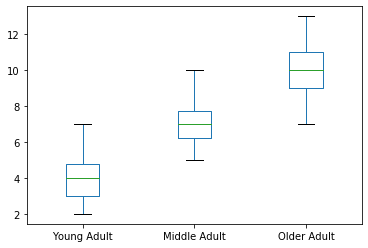

In [4]:
df.boxplot(column=['Young Adult', 'Middle Adult', 'Older Adult'], grid=False)

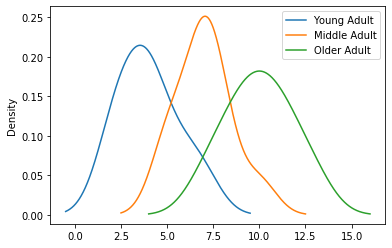

In [5]:
df.plot.kde()

#### Sprawdzamy czy wariancje w tych grupach są podobne.

In [6]:
k = df['Young Adult'].var(ddof=0)
print("'Young Adult:  ",'k=%.1f' % k)

k = df['Middle Adult'].var(ddof=0)
print("Middle Adult:  ",'k=%.1f' % k)

k = df['Older Adult'].var(ddof=0)
print("Older Adult:   ",'k=%.1f' % k)

'Young Adult:   k=2.4
Middle Adult:   k=2.0
Older Adult:    k=3.0


Wariancje mają zbliżoną wartoś, można zastosować test ANOVA.

Przekształcamy dataframe do postaci wymaganej przez statmodels.

In [7]:
df_melt = pd.melt(df.reset_index(),  id_vars=['Group'], value_vars=['Young Adult', 'Middle Adult', 'Older Adult'])
df_melt.sample(5)

,Group,variable,value
24,Male,Older Adult,11
20,Male,Older Adult,10
3,Male,Young Adult,4
16,Female,Middle Adult,10
2,Male,Young Adult,3


In [8]:
import statsmodels.api as sm
from statsmodels.formula.api import ols


model = ols('value ~ C(Group) + C(variable) + C(Group):C(variable)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Group),3.000000e+01,1.0,1.636364e+01,4.700077e-04
C(variable),1.800000e+02,2.0,4.909091e+01,3.299559e-09
C(Group):C(variable),1.183291e-29,2.0,3.227158e-30,1.000000e+00
Residual,4.400000e+01,24.0,NaN,NaN


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 1, 'Agitation by type of music')

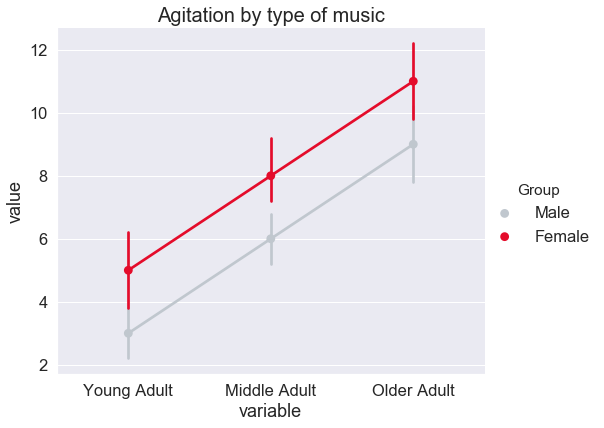

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

kot = ["#c0c7ce", "#e40c2b"]

sns.set(font_scale=1.5)
sns.factorplot('variable','value',hue='Group',data=df_melt , palette=kot, height=6, aspect=1.2)
plt.title('Agitation by type of music', fontsize=20)

#### Odrzucamy hipotezę H0a: Istnieją znaczące różnice pomiędzy płcią (F = 16,36, p=0,0004700077, p <0,01)

#### Odrzucamy hipotezę H0b: Istnieją znaczące różnice pomiędzy grupami wiekowymi (F = 49,09, p=0,000000003299559, p <0,01)

#### Zachowujemy hipotezę H0c: Brak efektu interakcji (F = 0,00, p=1 nieistotny).

Z danych wynika, że starsi dorośli mają najwyższy poziom zadowolenia z życia, a młodsi dorośli mają najniższy poziom zadowolenia z życia. Kobiety mają także znacznie wyższą satysfakcję z życia niż mężczyźni.

### Dzielimy grupę na mężczyzn i kobiety i oddzielnie testujemy Tukey HSD

In [10]:
Male = df_melt[df_melt['Group']=='Male']
Female = df_melt[df_melt['Group']=='Female']

# Tukey HSD Test dla mężczyzn 

In [11]:
import scipy.stats as stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,MultiComparison)

# Tworzę specjalną wartość
KOT = MultiComparison(Male['value'],Male['variable'])
AA = KOT.tukeyhsd()
print(AA.summary())

   Multiple Comparison of Means - Tukey HSD,FWER=0.05   
   group1       group2   meandiff  lower   upper  reject
--------------------------------------------------------
Middle Adult Older Adult   3.0     0.9345  5.0655  True 
Middle Adult Young Adult   -3.0   -5.0655 -0.9345  True 
Older Adult  Young Adult   -6.0   -8.0655 -3.9345  True 
--------------------------------------------------------


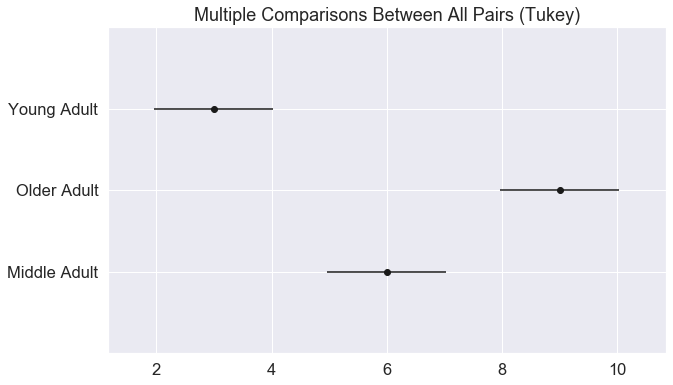

In [12]:
AA.plot_simultaneous()    
plt.vlines(x=160,ymin=-0.5,ymax=3.5, color="red")

Istnieją duże różnice w zadowoleniu z życia pomiędzy grupami mężczyzn: 'Young Adult', 'Middle Adult', 'Older Adult'.

### Test Bonferroniego
Jest to test substytucyjny do testu tukey HDS.

In [13]:
import scipy.stats as stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,MultiComparison)

# Tworzę specjalną wartość
KOT = MultiComparison(Male['value'],Male['variable'])
comp = KOT.allpairtest(stats.ttest_rel, method='Holm')
print (comp[0])

Test Multiple Comparison ttest_rel 
FWER=0.05 method=Holm
alphacSidak=0.02, alphacBonf=0.017
   group1       group2     stat   pval  pval_corr reject
--------------------------------------------------------
Middle Adult Older Adult -5.4772 0.0054   0.0108   True 
Middle Adult Young Adult  5.4772 0.0054   0.0108   True 
Older Adult  Young Adult  7.1714 0.002    0.006    True 
--------------------------------------------------------


# Tukey HSD Test dla kobiet

In [14]:
import scipy.stats as stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,MultiComparison)

# Tworzę specjalną wartość
KOT = MultiComparison(Female['value'],Female['variable'])
FF = KOT.tukeyhsd()
print(AA.summary())

   Multiple Comparison of Means - Tukey HSD,FWER=0.05   
   group1       group2   meandiff  lower   upper  reject
--------------------------------------------------------
Middle Adult Older Adult   3.0     0.9345  5.0655  True 
Middle Adult Young Adult   -3.0   -5.0655 -0.9345  True 
Older Adult  Young Adult   -6.0   -8.0655 -3.9345  True 
--------------------------------------------------------


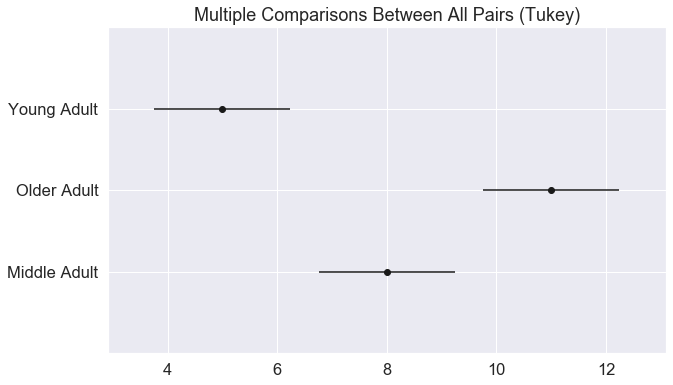

In [15]:
FF.plot_simultaneous()    
plt.vlines(x=160,ymin=-0.5,ymax=3.5, color="red")

Zarówno wśród kobiet jak i wśród mężczyzn istnieje wysoki poziom różnic pomiędzy grupami wiekowymi.